In [1]:
%matplotlib inline
from collections import defaultdict, OrderedDict
import functools as ft
import itertools as it
import math

import PIL
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext cython

In [3]:
bwimg = lambda width, height: Image.new('1', (width, height))
rgbimg = lambda width, height: Image.new('RGB', (width, height))

In [4]:
def repeat(*iterable, times=1):
    for _ in range(times):
        for item in iterable:
            yield item

# Noise

In [5]:
def white_noise(width, height):
    return np.random.randint(0, 2, size=im.height * im.width, dtype=np.uint8)

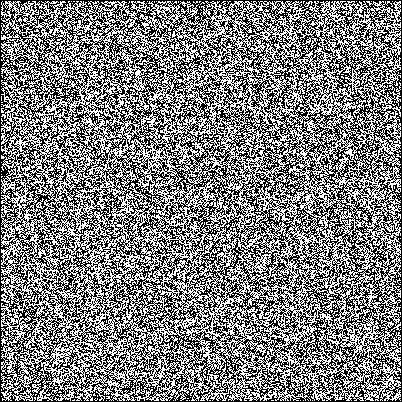

In [6]:
im = bwimg(400, 400)
im.putdata(white_noise(im.width, im.height))
ImageOps.expand(im, border=1, fill=0)

In [7]:
def rainbow_noise(width, height):
    return np.random.randint(0, 2**8 - 1, size=(width * height, 3), dtype=np.uint8)

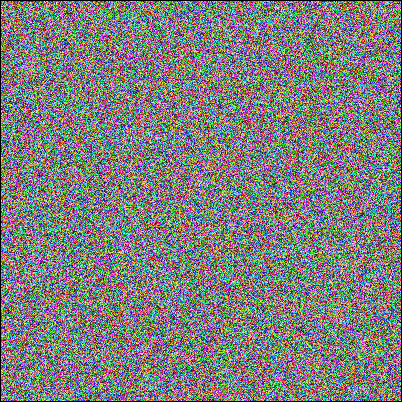

In [8]:
im = rgbimg(400, 400)
im.putdata(list(map(tuple, rainbow_noise(im.width, im.height))))
ImageOps.expand(im, border=1, fill=0)

# Half Black/Half White

In [9]:
def half_black_half_white(width, height):
    n = int(width * (height / 2))
    return np.append(np.zeros(n), np.ones(n))

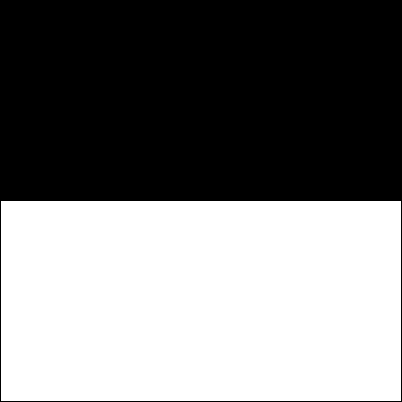

In [10]:
im = bwimg(400, 400)
im.putdata(half_black_half_white(im.width, im.height))
ImageOps.expand(im, border=1, fill=0)

# Stripes

In [11]:
def black_white_stripes(width, height, stripe_height=None):
    if not stripe_height or stripe_height > height:
        stripe_height = int(height / 10)
    n = width * stripe_height
    arr = np.append(np.zeros(n, dtype=np.uint8), np.ones(n, np.uint8)).reshape(1, -1, width)
    return np.repeat(arr, int(height / (stripe_height * 2)), axis=0).flatten()

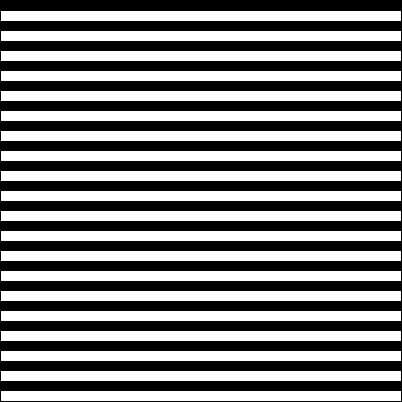

In [12]:
im = bwimg(400, 400)
im.putdata(black_white_stripes(im.width, im.height, 10))
ImageOps.expand(im, border=1, fill=0)

In [13]:
def draw_stripe(tmp, height=None):
    if not height:
        height = tmp.height * 2
    else:
        height = tmp.height + height
    im = rgbimg(tmp.width, height)
    im.paste(tmp)
    draw = ImageDraw.Draw(im)
    draw.rectangle([(0, tmp.height), (tmp.width, height)], 
                   fill=tuple(np.random.randint(0, 2**8 - 1, size=3)))
    return im

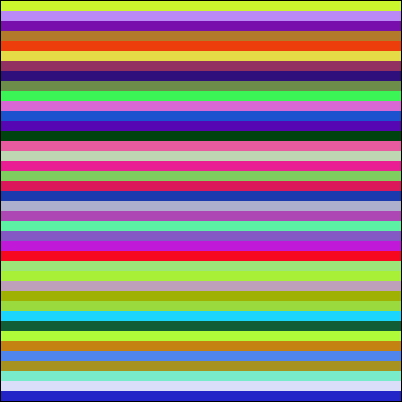

In [14]:
im = rgbimg(400, 0)
draw_stripe_p = ft.partial(draw_stripe, height=10)
im = ft.reduce(lambda x, f: f(x), repeat(draw_stripe_p, times=39), draw_stripe_p(im))
ImageOps.expand(im, border=1, fill=0)

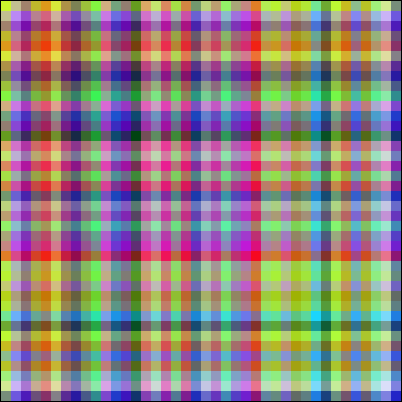

In [15]:
ImageOps.expand(Image.blend(im, im.rotate(90), 0.5), border=1, fill=0)

In [17]:
def rainbow_stripes(width, height, stripe_height=None, orient='horizontal'):
    if not stripe_height or stripe_height > height:
        stripe_height = int(height / 10)
    axis = int(orient == 'horizontal')
    arr = np.repeat(np.random.randint(0, 2**8 - 1, size=(1, im.width, 3)), im.height, axis=axis)
    return arr.reshape(-1, 3)

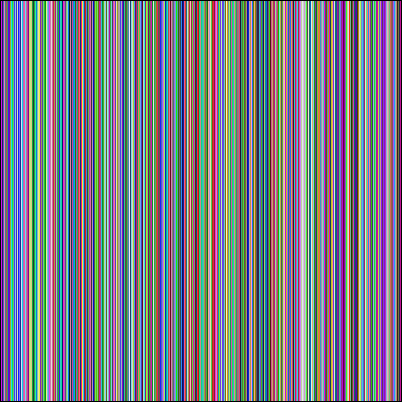

In [18]:
# vertical
vim = rgbimg(400, 400)
vim.putdata(list(map(tuple, rainbow_stripes(vim.width, vim.height, orient='vertical'))))
ImageOps.expand(vim, border=1, fill=0)

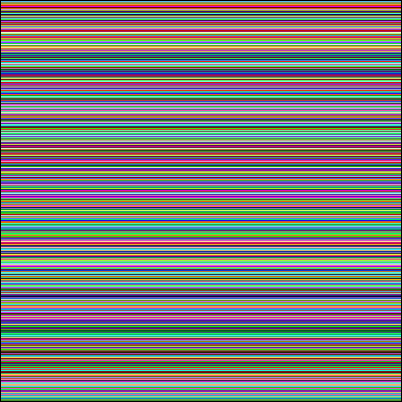

In [19]:
# horizontal
him = rgbimg(400, 400)
him.putdata(list(map(tuple, rainbow_stripes(him.width, him.height))))
ImageOps.expand(him, border=1, fill=0)

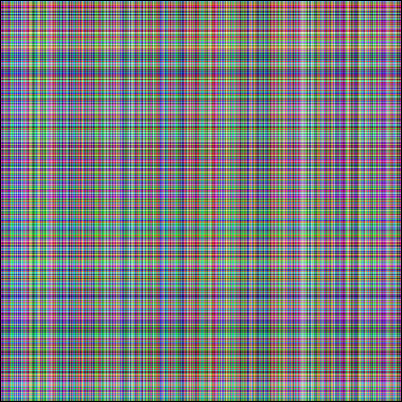

In [20]:
# blended
blended_im = Image.blend(vim, him, 0.5)
ImageOps.expand(blended_im, border=1, fill=0)

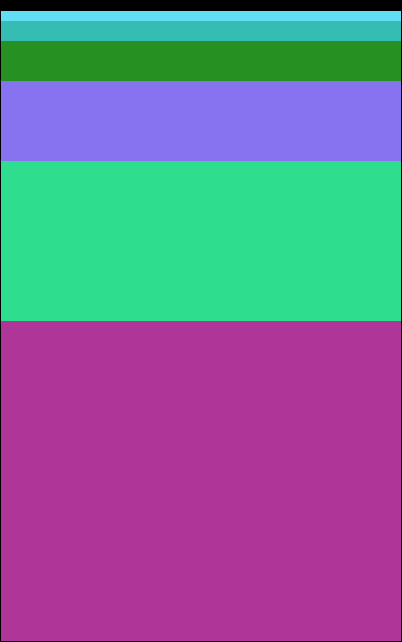

In [21]:
im = rgbimg(400, 10)
im = ft.reduce(lambda x, f: f(x), repeat(draw_stripe, times=5), draw_stripe(im))
ImageOps.expand(im, border=1, fill=0)

# Pixel Checker Board

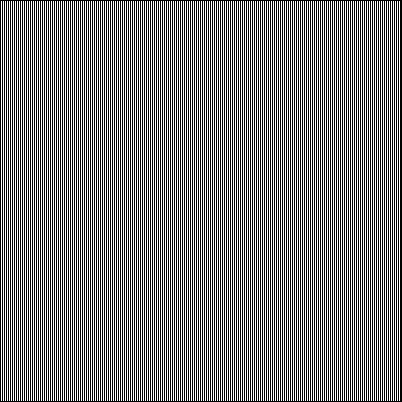

In [22]:
im = bwimg(400, 400)
arr = np.arange(im.height * im.width)
im.putdata(np.where(arr % 2 == 0, 1, 0))
ImageOps.expand(im, border=1, fill=0)

# Checker Board

In [23]:
def mirror(tmp):
    im = bwimg(tmp.width * 2, tmp.height)
    im.paste(tmp)
    im.paste(tmp, box=(tmp.width, 0))
    return im

In [24]:
def flip(tmp):
    im = bwimg(tmp.width, tmp.height * 2)
    im.paste(tmp)
    im.paste(tmp, box=(0, tmp.height))
    return im

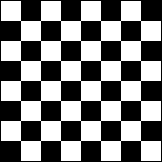

In [25]:
im = bwimg(40, 40)
draw = ImageDraw.Draw(im)
hh = int(im.height / 2)
hw = int(im.width / 2)
draw.rectangle([(0, 0), (hw - 1, hh - 1)], fill=1)
draw.rectangle([(hw, hh), (im.width - 1, im.height - 1)], fill=1)
im = ft.reduce(lambda x, f: f(x), repeat(flip, mirror, times=2), im)
ImageOps.expand(im, border=1, fill=0)

# Squares all the way in

In [26]:
def draw_right_angle(arr, i, color):
    arr[i, i:] = color
    arr.T[i, i:] = color

In [27]:
def make_square(ulc):
    uh = np.array([np.array(t).flatten() for t in zip(ulc, np.flip(ulc, axis=1))])
    return np.array([uh, np.flip(uh, axis=0)]).flatten()

In [28]:
def draw_squares(x, width=None):
    if not width:
        width = int(x / 10)
    initial = np.zeros((x, x))
    color = True
    for i in range(0, initial.shape[0], width):
        for j in range(i, i + width):
            draw_right_angle(initial, j, color=int(color))
        color = not color
    im = bwimg(x * 2, x * 2)
    im.putdata(make_square(initial))
    return im

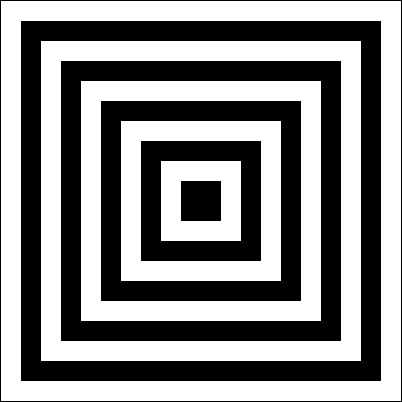

In [29]:
ImageOps.expand(draw_squares(200, width=20), border=1, fill=0)

# Random dots of varying frequency in a circle

In [30]:
def even_prob_segmenter(arange, start_prob=0.50, end_prob=0.05):
    prob_step = (start_prob - end_prob) / len(arange)
    return np.arange(start_prob, end_prob, -prob_step).astype(np.float32)

In [ ]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp
from libc.stdlib cimport rand, RAND_MAX, srand
from ctypes import sizeof
cimport cython
from cython.parallel import parallel, prange, threadid
cimport numpy as np
import numpy as np


@cython.cdivision(True)
cdef float rand_float() nogil:
    return float(rand()) / float(RAND_MAX)


@cython.wraparound(False)
@cython.boundscheck(False)
cpdef np.ndarray[dtype=np.int_t, ndim=2] plot_points(
    np.ndarray[dtype=np.float32_t, ndim=2] dist_grid,
    np.ndarray[dtype=np.int_t] dist_thresh,
    np.ndarray[dtype=np.float32_t] rand_thresh
):
    srand(0)
    cdef np.ndarray[dtype=np.int_t, ndim=2] result = np.zeros(
        [dist_grid.shape[0], dist_grid.shape[1]], dtype=np.int
    )
    cdef float r
    cdef int x, y, i
    #for x in prange(dist_grid.shape[0], nogil=True):
    for x in range(dist_grid.shape[0]):
        for y in range(dist_grid.shape[1]):
            r = rand_float()
            for i in range(dist_thresh.shape[0]):
                if dist_grid[x, y] < dist_thresh[i]:
                    if r < rand_thresh[i]:
                        result[x, y] = 1
                    break
    return result

In [ ]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp -lm
from libc.stdlib cimport abs
from libc.math cimport pow, sqrt
cimport cython
from cython.parallel import parallel, prange, threadid
cimport numpy as np
import numpy as np
    
    
cdef float pointdist(int x1, int y1, int x2, int y2) nogil:
    return sqrt(pow(abs(x1 - x2), 2) + pow(abs(y1 - y2), 2))


@cython.wraparound(False)
@cython.boundscheck(False)
cpdef np.ndarray[dtype=np.float32_t, ndim=2] mkdistgrid(int ox, int oy, int width, int height):
    cdef np.ndarray[dtype=np.float32_t, ndim=2] distgrid = np.empty([width, height], dtype=np.float32)
    cdef int x, y
    for x in prange(width, nogil=True):
        for y in range(height):
            distgrid[x, y] = pointdist(ox, oy, x, y)
    return distgrid

In [33]:
def dot_circle(width, height):
    origin = int(im.width / 2), int(im.height / 2)
    point_dists = mkdistgrid(origin[0], origin[1], width, height)
    dist_thresh = np.arange(10, origin[0], 10)
    prob_thresh = even_prob_segmenter(dist_thresh, start_prob=1)
    return plot_points(point_dists, dist_thresh, prob_thresh).flatten()

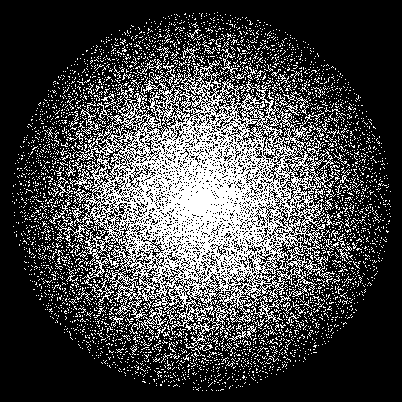

In [34]:
im = bwimg(400, 400)
circle_arr = dot_circle(im.width, im.height)
im.putdata(circle_arr)
ImageOps.expand(im, border=1, fill=0)

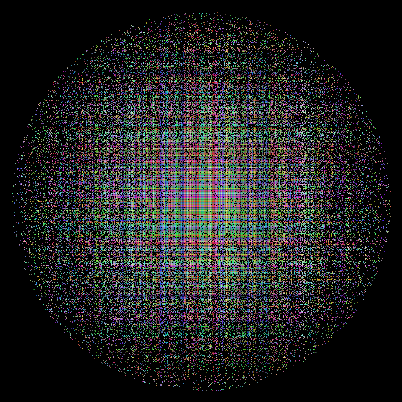

In [35]:
im = rgbimg(400, 400)
data = np.where(dot_circle(im.width, im.height).reshape(-1, 1), 
                np.asarray(blended_im).reshape(-1, 3), 
                [0, 0, 0])
im.putdata(list(map(tuple, data)))
ImageOps.expand(im, border=1, fill=0)

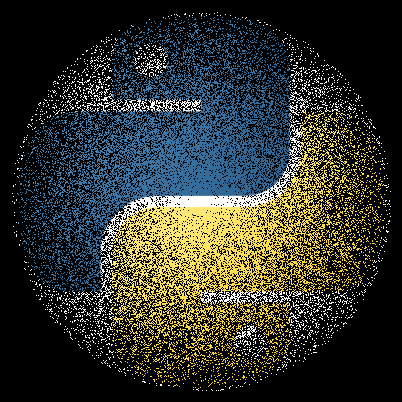

In [36]:
im = rgbimg(400, 400)
data = np.where(dot_circle(im.width, im.height).reshape(-1, 1), 
                np.asarray(Image.open('./pythonlogo.png')).reshape(-1, 4), 
                [0, 0, 0, 0])
im.putdata(list(map(tuple, data)))
ImageOps.expand(im, border=1, fill=0)

# Parallel cython test

In [ ]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp
cimport cython
from cython.parallel import prange, threadid
cimport numpy as np
import numpy as np


@cython.boundscheck(False)
cpdef np.ndarray[dtype=np.int_t] partest(np.ndarray[dtype=np.int_t] arr):
    cdef int n = arr.shape[0]
    cdef np.ndarray[dtype=np.int_t] result = np.empty(n, dtype=np.int)
    cdef int i
    for i in prange(n, nogil=True):
        result[i] = arr[i] * threadid()
    return result

In [38]:
partest(np.ones(100, dtype=np.int))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])